# **Latar Belakang**

Shopee merupakan salah satu marketplace belanja online yang cukup populer di Indonesia. Selain itu, shopee juga cukup memanjakan penggunakanya dimana marketplace ini memberikan potongan harga, voucher, gratis ongkir, shopee koin dan permainan yang dapat menghasilkan keuntungan lainnya.
Namun tidak dapat dipungkiri, bahwa marketplace ini juga mendapatkan sentimen negatif dari penggunanya. Untuk itu, saya mencoba untuk melihat kepuasan pengguna shopee yang ada di Play Store.

# Import Libary

In [1]:
pip install google-play-scraper

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from wordcloud import WordCloud

from google_play_scraper import app
from google_play_scraper import Sort, reviews

# Wragling Data

## Scrapping Data

In [3]:
!pip install google-play-scraper

In [4]:
result, continuation_token = reviews(
    'com.shopee.id',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=1000,
    filter_score_with=None
)
data = pd.DataFrame(result)

In [5]:
print(data.columns)

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion'],
      dtype='object')


In [6]:
# mengambil kolom yang diperlukan untuk analisa

data = data[['content']]
data.columns = ['content']
data.head()

,content
0,"Shopee bikin kecewa, puluhan paket ku kandas d..."
1,"Sebelum diupdate aplikasi berjalan normal,tapi..."
2,Buat yang suka belanja bisa manfaatkan shoope ...
3,"Jaringan bagus & stabil sampai 25Mbps, hp juga..."
4,Habis di-update malah makin parah. Jaringan da...


## Assesing Data

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [8]:
data.isnull().sum()

content    0
dtype: int64

In [9]:
data.duplicated().sum()

3

In [10]:
data.describe()

,content
count,1000
unique,997
top,Kurang nyaman dengan teror2 yg dilakukan oleh ...
freq,2


In [11]:
data.shape

(1000, 1)

# Simpan Data Ke Gdrive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

import os
default_dir = "/content/drive/MyDrive/Colab Notebooks/Analisis Sentimen Review Shopee"
os.chdir(default_dir)

Mounted at /content/drive


In [13]:
data.to_excel('Shopee_IDN_PlayStore.xlsx', index = False)

# Library NLTK

In [14]:
import nltk
nltk.download('stopwords')

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Prepocessing Data

In [15]:
df = data.copy()

## Normalisasi Data

In [16]:
def normalize_text(text):
  text = text.lower()
  text = text.strip(" ")
  text = re.sub(r'[?|$|.|!_:")(-+,]', '', text)
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'[^a-zA-Z. ]', '', text)
  text = re.sub(r'\s+', ' ', text)
  text = re.sub(r'(.)\1+', r'\1', text)  # Normalisasi huruf berlebihan
  return text

df['content'] = df['content'].apply(normalize_text)
df.head(10)

,content
0,shope bikin kecewa puluhan paket ku kandas dij...
1,sebelum diupdate aplikasi berjalan normaltapi ...
2,buat yang suka belanja bisa manfatkan shope de...
3,jaringan bagus stabil sampai mbps hp juga mode...
4,habis diupdate malah makin parah jaringan data...
5,aplikasi semakin lemot jaringan bagus dengan k...
6,maf saya rubah dulu bintangnya dari ke karena ...
7,saya menungu pesanan saya setengah bulan lebih...
8,shope dari dulu nga ada perubahan sama sekali ...
9,di bandingin online shop yg lain saya lebih me...


In [17]:
norm = {
     " apk " : " aplikasi ", " app " : " aplikasi ",
     " b " : " biasa ",  " blm " : " belum "," bgs " : " bagus ", " bgt " : " banget ",
     " cman " : " cuman ",  " cb " : " coba ",
     " dgn " : " dengan ",  " dg " : " dengan ", " dr " : " dari ", " dpt " : " dapat ",  " dlu " : " dulu ",
     " dah " : " sudah ", " udh " : " sudah ", " emg " : " memang ", " mmg " : "memang",
     " ga " : " tidak ", " gx " : " tidak ", " gk " : " gak ", " ngk " : " tidak ",  " gak " : " tidak ",
     " gw " : " saya ",  " sy " : " saya ", " jlk " : " jelek ", " jlek " : " jelek ", " jgn " : " jangan ",
     " klu " : " kalau ", " ksh " : " kasih ",  " knp " : " kenapa ", " lbh " : " lebih ",
     " mlz " : " malas ", " maap " : " maaf ", " lemot ": " lelet ",
     " tp " : " tapi ",  " ttp " : " tetapi ", " tpi " : " tapi ",  " tdk " : " tidak ",
     " trs" : " terus ",  " tgl " : " tanggal ", "tf" : " transfer ", " tlg " : " tolong ",
     " tq" : "terima kasih", " trims" : " terima kasih ", " thx " : " terima kasih ",
     " shoppe " : " shopee"
}

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

df['content'] = df['content'].apply(lambda x: normalisasi(x))

In [18]:
df.head()

,content
0,shope bikin kecewa puluhan paket ku kandas dij...
1,sebelum diupdate aplikasi berjalan normaltapi ...
2,buat yang suka belanja bisa manfatkan shope de...
3,jaringan bagus stabil sampai mbps hp juga mode...
4,habis diupdate malah makin parah jaringan data...


## Tokenizing
Pisahkan teks menjadi token (kata-kata atau frasa) agar dapat dianalisis lebih lanjut.

In [19]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

df['token'] = df['content'].apply(lambda x: word_tokenize(x))
df.head(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,content,token
0,shope bikin kecewa puluhan paket ku kandas dij...,"[shope, bikin, kecewa, puluhan, paket, ku, kan..."
1,sebelum diupdate aplikasi berjalan normaltapi ...,"[sebelum, diupdate, aplikasi, berjalan, normal..."
2,buat yang suka belanja bisa manfatkan shope de...,"[buat, yang, suka, belanja, bisa, manfatkan, s..."
3,jaringan bagus stabil sampai mbps hp juga mode...,"[jaringan, bagus, stabil, sampai, mbps, hp, ju..."
4,habis diupdate malah makin parah jaringan data...,"[habis, diupdate, malah, makin, parah, jaringa..."
5,aplikasi semakin lelet jaringan bagus dengan k...,"[aplikasi, semakin, lelet, jaringan, bagus, de..."
6,maf saya rubah dulu bintangnya dari ke karena ...,"[maf, saya, rubah, dulu, bintangnya, dari, ke,..."
7,saya menungu pesanan saya setengah bulan lebih...,"[saya, menungu, pesanan, saya, setengah, bulan..."
8,shope dari dulu nga ada perubahan sama sekali ...,"[shope, dari, dulu, nga, ada, perubahan, sama,..."
9,di bandingin online shop yg lain saya lebih me...,"[di, bandingin, online, shop, yg, lain, saya, ..."


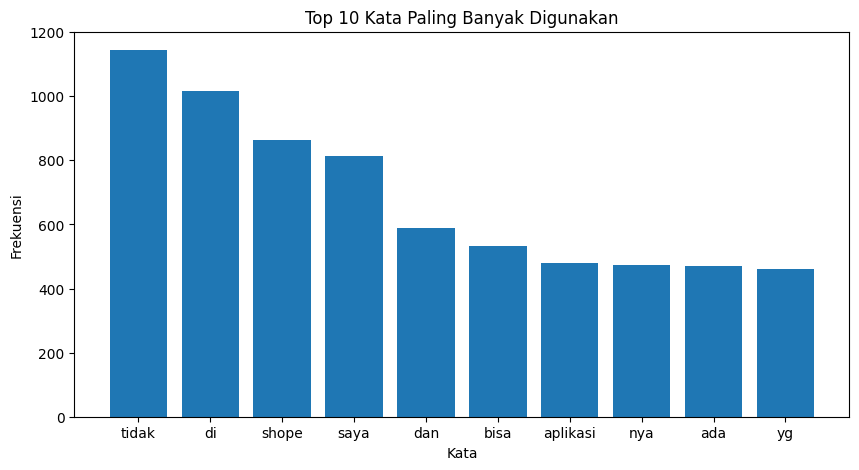

In [20]:
from collections import Counter

# Flatten the lists of tokens in the 'token' column
all_tokens = [token for tokens_list in df['token'] for token in tokens_list]

# Get word frequencies using Counter
word_freq = Counter(all_tokens)

# Get the top 10 most common words
top_words = word_freq.most_common(10)

# Visualization with a bar chart
plt.figure(figsize=(10, 5))
plt.bar(*zip(*top_words))
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Top 10 Kata Paling Banyak Digunakan')
plt.show()

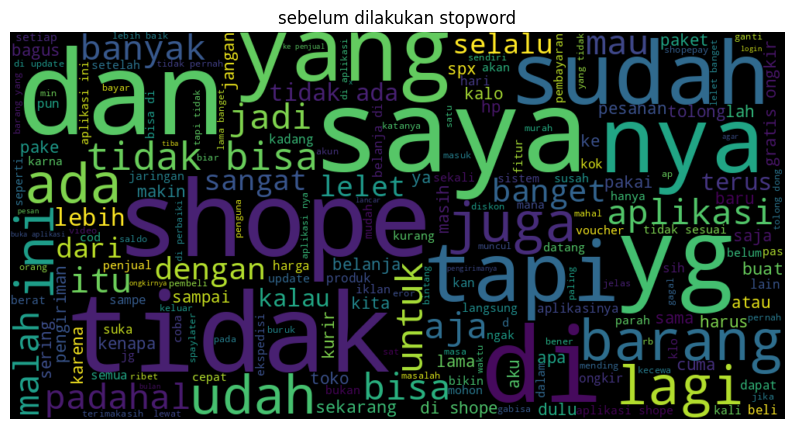

In [21]:
all_tokens = [token for tokens_list in df['token'] for token in tokens_list]
tokens_string = ' '.join(all_tokens)

# membuat Word Cloud
wordcloud = WordCloud(width=1000, height=500, max_font_size=150, random_state=42).generate(tokens_string)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('sebelum dilakukan stopword')
plt.show()

## Stopword
kata-kata umum yang tidak memberikan makna seperti "dan", "atau", dll.

In [22]:
pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.9 MB/s eta 0:00:00


In [23]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [24]:
# Inisialisasi StopWordRemoverFactory
stopword_factory = StopWordRemoverFactory()
stop_factory = StopWordRemoverFactory()

# Daftar stopwords bawaan dari Sastrawi
default_stopwords = stop_factory.get_stop_words()

# Stopwords tambahan
more_stopwords = [
    'ada', 'di', 'nya', 'aja', 'tapi', 'sudah', 'ada', 'cuman', 'bgt', 'sih',
    'lah', 'kah', 'ini', 'dgn', 'apa', 'lagi', 'aja', 'saja', 'yg', 'knp', 'di', 'klo', 'skrg', 'yg',
    'jd', 'sdh', 'jg', 'tgl', 'y', 'g', 'jngn', 'jgn', 'bln', 'coy', 'kuy', 'sll', 'org', 'mjd', 'rek',
    'utk', 'gt', 'ko', 'kok', 'loh', 'toh', 'moh', 'da', 'hai', 'td', 'x', 'tapi', 'ya', 'say', 'min',
    'bro', 'sis', 'k', 'saya', 'bisa'
]

# Gabungkan daftar stopwords
combined_stopwords = default_stopwords + more_stopwords

def stopword_removal(ulasan):
  filtering = combined_stopwords

  x = []
  df = []

  def myFunc(x):
    if x in filtering:
      return False
    else :
      return True

  fit = filter(myFunc, ulasan)
  for x in fit :
    df.append(x)
  return df

df['token'] = df['token'].apply(stopword_removal)
df.head(10)

,content,token
0,shope bikin kecewa puluhan paket ku kandas dij...,"[shope, bikin, kecewa, puluhan, paket, ku, kan..."
1,sebelum diupdate aplikasi berjalan normaltapi ...,"[diupdate, aplikasi, berjalan, normaltapi, diu..."
2,buat yang suka belanja bisa manfatkan shope de...,"[buat, suka, belanja, manfatkan, shope, berbag..."
3,jaringan bagus stabil sampai mbps hp juga mode...,"[jaringan, bagus, stabil, mbps, hp, model, ter..."
4,habis diupdate malah makin parah jaringan data...,"[habis, diupdate, malah, makin, parah, jaringa..."
5,aplikasi semakin lelet jaringan bagus dengan k...,"[aplikasi, semakin, lelet, jaringan, bagus, ke..."
6,maf saya rubah dulu bintangnya dari ke karena ...,"[maf, rubah, dulu, bintangnya, semakin, kesini..."
7,saya menungu pesanan saya setengah bulan lebih...,"[menungu, pesanan, setengah, bulan, lebih, tib..."
8,shope dari dulu nga ada perubahan sama sekali ...,"[shope, dulu, nga, perubahan, sama, sekali, ka..."
9,di bandingin online shop yg lain saya lebih me...,"[bandingin, online, shop, lebih, memilih, shop..."


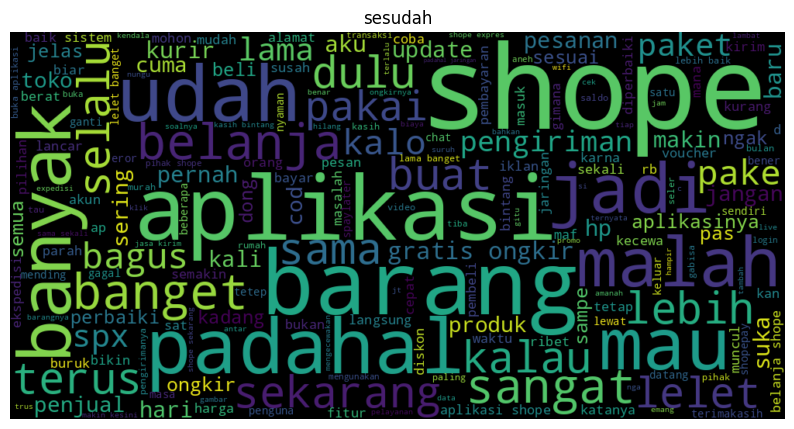

In [25]:
# wordcloud untuk melihat banyak kalimat
all_text = ' '.join([' '.join(tokens) for tokens in df['token']])

# membuat Word Cloud
wordcloud = WordCloud(width=1000, height=500, max_font_size=150, random_state=42).generate(all_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('sesudah')
plt.show()

## Stemming
proses linguistik di bidang pemrosesan bahasa alami yang bertujuan untuk menghilangkan infleksi atau afiksasi dari kata-kata.

In [26]:
from sklearn.pipeline import Pipeline
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [27]:
def stemming(tokens):

    # Inisialisasi Stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Proses stemming untuk setiap token
    stemmed_tokens = [stemmer.stem(kata) for kata in tokens]

    # Menggabungkan hasil stemming menjadi satu string
    data_clean = " ".join(stemmed_tokens)

    return data_clean
df['stemming_token'] = df['token'].apply(stemming)

In [29]:
df

,content,token,stemming_token
0,shope bikin kecewa puluhan paket ku kandas dij...,"[shope, bikin, kecewa, puluhan, paket, ku, kan...",shope bikin kecewa puluh paket ku kandas jalan...
1,sebelum diupdate aplikasi berjalan normaltapi ...,"[diupdate, aplikasi, berjalan, normaltapi, diu...",diupdate aplikasi jalan normaltapi diupdate ma...
2,buat yang suka belanja bisa manfatkan shope de...,"[buat, suka, belanja, manfatkan, shope, berbag...",buat suka belanja manfatkan shope bagai pilih ...
3,jaringan bagus stabil sampai mbps hp juga mode...,"[jaringan, bagus, stabil, mbps, hp, model, ter...",jaring bagus stabil mbps hp model baru udah fl...
4,habis diupdate malah makin parah jaringan data...,"[habis, diupdate, malah, makin, parah, jaringa...",habis diupdate malah makin parah jaring data s...
...,...,...,...
995,di update malah jadi tambah parah menyesal aku...,"[update, malah, jadi, tambah, parah, menyesal,...",update malah jadi tambah parah sesal aku updat...
996,status diterima tapi barang tidak ada bisakah ...,"[status, diterima, barang, bisakah, dikirim, u...",status terima barang bisa kirim ulang uang kem...
997,makin sini shope makin ngelunjak dan parah ken...,"[makin, sini, shope, makin, ngelunjak, parah, ...",makin sini shope makin ngelunjak parah kena bi...
998,kurang nyaman dengan teror yg dilakukan oleh p...,"[kurang, nyaman, teror, dilakukan, penagihan, ...",kurang nyaman teror laku tagih spinjam galbay ...


## Sentimen Analis

In [30]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

SentimentIntensityAnalyzer dari NLTK membutuhkan input berupa string, oleh sebab itu data akan diubah menjdi string terlebih dahulu.

In [31]:
df['stemming_token'] = df['stemming_token'].astype('string')

In [32]:
df.dtypes

content           object
token             object
stemming_token    string
dtype: object

In [34]:
analisa = SentimentIntensityAnalyzer()

# Sentiment Analysis:
df['compound'] =  df['stemming_token'].apply(lambda x: analisa.polarity_scores(x)['compound'])
# Sentiment Labeling
df['sentiment_label'] = df['compound'].apply(lambda x: 'positif' if x > 0 else ('negatif' if x < 0 else 'netral'))

df.drop(columns='stemming_token')

,content,token,sentiment,sentiment_label,compound
0,shope bikin kecewa puluhan paket ku kandas dij...,"[shope, bikin, kecewa, puluhan, paket, ku, kan...",0.0000,netral,0.0000
1,sebelum diupdate aplikasi berjalan normaltapi ...,"[diupdate, aplikasi, berjalan, normaltapi, diu...",0.0000,netral,0.0000
2,buat yang suka belanja bisa manfatkan shope de...,"[buat, suka, belanja, manfatkan, shope, berbag...",0.7906,positif,0.7906
3,jaringan bagus stabil sampai mbps hp juga mode...,"[jaringan, bagus, stabil, mbps, hp, model, ter...",0.1027,positif,0.1027
4,habis diupdate malah makin parah jaringan data...,"[habis, diupdate, malah, makin, parah, jaringa...",0.0000,netral,0.0000
...,...,...,...,...,...
995,di update malah jadi tambah parah menyesal aku...,"[update, malah, jadi, tambah, parah, menyesal,...",0.3612,positif,0.3612
996,status diterima tapi barang tidak ada bisakah ...,"[status, diterima, barang, bisakah, dikirim, u...",0.0000,netral,0.0000
997,makin sini shope makin ngelunjak dan parah ken...,"[makin, sini, shope, makin, ngelunjak, parah, ...",0.0000,netral,0.0000
998,kurang nyaman dengan teror yg dilakukan oleh p...,"[kurang, nyaman, teror, dilakukan, penagihan, ...",0.0000,netral,0.0000


In [35]:
df.sentiment_label.value_counts()

netral     716
positif    193
negatif     91
Name: sentiment_label, dtype: int64

Mengambil kolom yang dibutuhkan dalam analisa lanjutaan.

In [36]:
ulasan_df = df[['content', 'sentiment_label']]
ulasan_df

,content,sentiment_label
0,shope bikin kecewa puluhan paket ku kandas dij...,netral
1,sebelum diupdate aplikasi berjalan normaltapi ...,netral
2,buat yang suka belanja bisa manfatkan shope de...,positif
3,jaringan bagus stabil sampai mbps hp juga mode...,positif
4,habis diupdate malah makin parah jaringan data...,netral
...,...,...
995,di update malah jadi tambah parah menyesal aku...,positif
996,status diterima tapi barang tidak ada bisakah ...,netral
997,makin sini shope makin ngelunjak dan parah ken...,netral
998,kurang nyaman dengan teror yg dilakukan oleh p...,netral


## Label Encoding

In [37]:
ulasan_df = ulasan_df.replace({'negatif':-1, 'netral':0, 'positif':1})
ulasan_df

,content,sentiment_label
0,shope bikin kecewa puluhan paket ku kandas dij...,0
1,sebelum diupdate aplikasi berjalan normaltapi ...,0
2,buat yang suka belanja bisa manfatkan shope de...,1
3,jaringan bagus stabil sampai mbps hp juga mode...,1
4,habis diupdate malah makin parah jaringan data...,0
...,...,...
995,di update malah jadi tambah parah menyesal aku...,1
996,status diterima tapi barang tidak ada bisakah ...,0
997,makin sini shope makin ngelunjak dan parah ken...,0
998,kurang nyaman dengan teror yg dilakukan oleh p...,0


In [40]:
ulasan_df.sentiment_label.value_counts()

 1    193
-1     91
Name: sentiment_label, dtype: int64

In [39]:
# menghapus sentimen netral
print(ulasan_df.shape)
ulasan_df = ulasan_df[ulasan_df['sentiment_label'] != 0]
print(ulasan_df.shape)

(1000, 2)
(284, 2)


# Visualisai Kata Berdasarkan Sentiment

In [41]:
negatif_df = ulasan_df[ulasan_df['sentiment_label'] == -1]
positif_df = ulasan_df[ulasan_df['sentiment_label'] == 1]

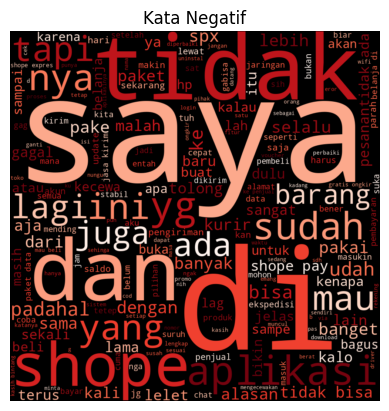

In [42]:
# Combine all text in the 'content' column
all_text = ' '.join(word for word in negatif_df['content'] if isinstance(word, str))

# Generate Word Cloud
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000).generate(all_text)

# Display the Word Cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Kata Negatif')
plt.show()

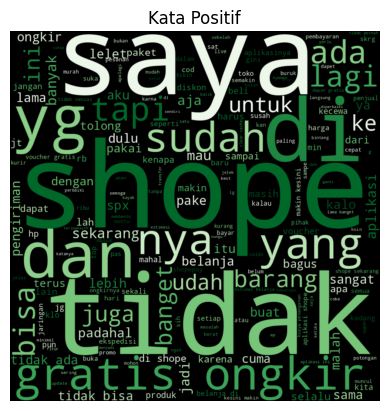

In [43]:
# Combine all text in the 'content' column
all_text = ' '.join(word for word in positif_df['content'] if isinstance(word, str))

# Generate Word Cloud
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000).generate(all_text)

# Display the Word Cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Kata Positif')
plt.show()

<Axes: >

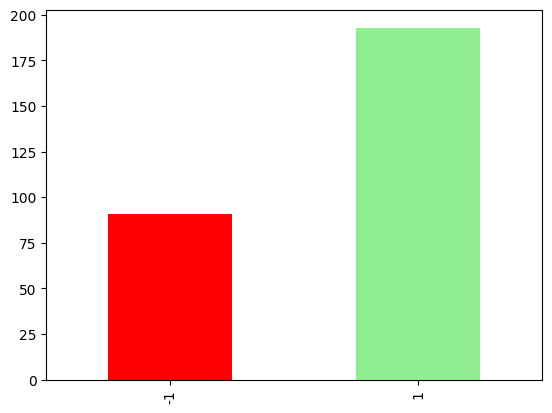

In [48]:
sort_ulasan_df = ulasan_df['sentiment_label'].value_counts().sort_index()
sort_ulasan_df.plot(kind='bar', color=['red', 'lightgreen'])

Dapat dilihat bahwa ulasan negatif lebih banyak dari pada ulasan positif.

# TFIDF

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [63]:
X = ulasan_df['content']
y = ulasan_df['sentiment_label']

# Bagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
# Vektorisasi data
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [105]:
# Konversi representasi sparse matrix ke array NumPy
X_train_array = X_train_vectorized.toarray()
X_test_array = X_test_vectorized.toarray()

# Model

In [106]:
# Libary

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [107]:
# Pilih model dan latih
nb_model = MultinomialNB()
nb_model.fit(X_train_array, y_train)

# Lakukan prediksi dan evaluasi
y_pred = nb_model.predict(X_test_array)

In [108]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print('')

# Hitung dan tampilkan confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print('')

# Tampilkan classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8421052631578947

Confusion Matrix:
 [[11  8]
 [ 1 37]]

Classification Report:
               precision    recall  f1-score   support

          -1       0.92      0.58      0.71        19
           1       0.82      0.97      0.89        38

    accuracy                           0.84        57
   macro avg       0.87      0.78      0.80        57
weighted avg       0.85      0.84      0.83        57



1. Recall mengukur seberapa baik model dapat menemukan kembali semua instance yang benar dari kelas positif.
2. F1-score adalah harmonic mean dari presisi dan recall. Ini memberikan gambaran keseluruhan tentang kinerja model yang seimbang antara presisi dan recall.
3. Support adalah jumlah sebenarnya dari setiap kelas dalam data pengujian.
4. Macro avg adalah rata-rata dari metrik evaluasi untuk setiap kelas, tanpa memperhitungkan frekuensi kelas.
5. Weighted avg memberikan bobot pada setiap kelas berdasarkan jumlah instance kelas tersebut.


# Visualisasi

In [100]:
!pip install --upgrade scikit-learn

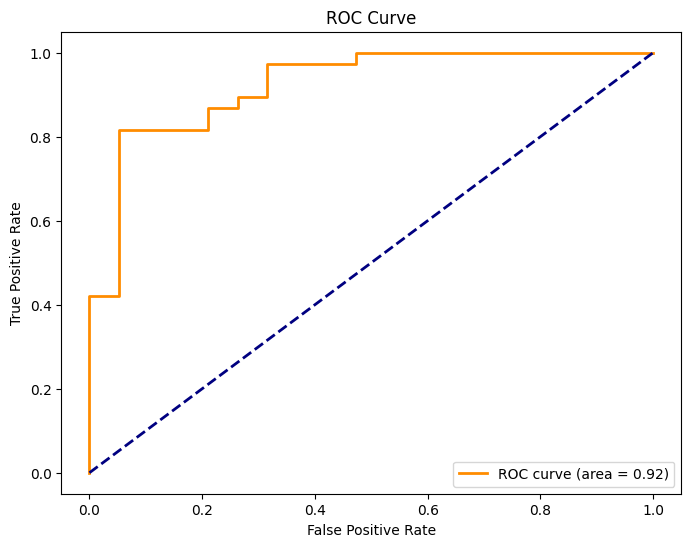

In [103]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, nb_model.predict_proba(X_test_array)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()